# Coastal Change

**Description: **

In [22]:
%matplotlib inline

from datetime import datetime

import datacube
import utils.dc_utilities as utils

from utils.dc_mosaic import create_mosaic
from utils.dc_water_classifier import *

import warnings; warnings.simplefilter('ignore')

In [23]:
start_time = datetime.now()
print("Start time: " + str(start_time))

Start time: 2017-01-30 15:32:34.204914


In [24]:
# Initialize data cube object
dc = datacube.Datacube(app='dc-coastal-erosion')

# Set query parameters
platform        = 'LANDSAT_7'
product_type    = 'ls7_ledaps_togo'

min_lon         = 1.1919
max_lon         = 1.4509
min_lat         = 6.0809
max_lat         = 6.2218

In [25]:
start_date      = datetime.strptime('2000-01-01', '%Y-%m-%d')
end_date        = datetime.strptime('2000-12-31', '%Y-%m-%d')

In [26]:
# Retrieve data from Data Cube
dataset_in_2000 = dc.load(platform=platform,
                          product=product_type,
                          time=(start_date, end_date),
                          lon=(min_lon, max_lon),
                          lat=(min_lat, max_lat))

In [27]:
start_date      = datetime.strptime('2015-01-01', '%Y-%m-%d')
end_date        = datetime.strptime('2015-12-31', '%Y-%m-%d')

In [28]:
# Retrieve data from Data Cube
dataset_in_2015 = dc.load(platform=platform,
                          product=product_type,
                          time=(start_date, end_date),
                          lon=(min_lon, max_lon),
                          lat=(min_lat, max_lat))

In [29]:
mosaic_2000 = create_mosaic(dataset_in_2000)
mosaic_2015 = create_mosaic(dataset_in_2015)

In [30]:
water_class_2000 = wofs_classify(mosaic_2000, mosaic=True)
water_class_2000.wofs.values[water_class_2000.wofs.values == -9999] = np.nan

water_class_2015 = wofs_classify(mosaic_2015, mosaic=True)
water_class_2015.wofs.values[water_class_2015.wofs.values == -9999] = np.nan

wofs_2000 = water_class_2000.wofs.values
wofs_2015 = water_class_2015.wofs.values

In [31]:
coastal_change = water_class_2015 - water_class_2000

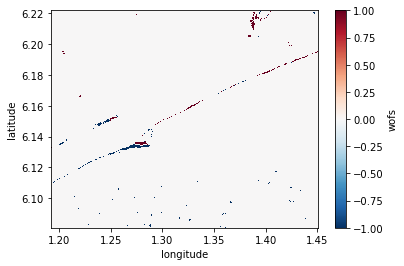

In [32]:
# -1 -> water to coast
#  0 -> no change
#  1 -> coast to water (Coastal Erosion)

coastal_change.wofs.plot()

In [33]:
coastline_2000 = np.zeros(wofs_2000.shape)

for i in range(wofs_2000.shape[0]):
    for j in range(wofs_2000.shape[1]):
        pixel = wofs_2000[i,j]
        if pixel == 0 and np.nansum(wofs_2000[i-1:i+2, j-1:j+2]) >= 1 and np.nansum(wofs_2000[i-1:i+2, j-1:j+2]) <= 5:
            coastline_2000[i,j] = 1
            
coastline_2015 = np.zeros(wofs_2015.shape)

for i in range(wofs_2015.shape[0]):
    for j in range(wofs_2015.shape[1]):
        pixel = wofs_2015[i,j]
        if pixel == 0 and np.nansum(wofs_2015[i-1:i+2, j-1:j+2]) >= 1 and np.nansum(wofs_2015[i-1:i+2, j-1:j+2]) <= 5:
            coastline_2015[i,j] = 1

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [35]:
from pylab import *

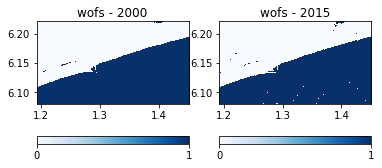

In [36]:
fig = plt.figure()
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(wofs_2000, cmap='Blues',
                     extent=[water_class_2000.longitude.values.min(), 
                             water_class_2000.longitude.values.max(),
                             water_class_2000.latitude.values.min(),
                             water_class_2000.latitude.values.max()])
a.set_title('wofs - 2000')
plt.colorbar(ticks=[0,1], orientation ='horizontal')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(wofs_2015, cmap='Blues',
                     extent=[water_class_2015.longitude.values.min(), 
                             water_class_2015.longitude.values.max(),
                             water_class_2015.latitude.values.min(),
                             water_class_2015.latitude.values.max()])
#imgplot.set_clim(0.0,1.0)
a.set_title('wofs - 2015')
plt.colorbar(ticks=[0,1], orientation='horizontal')
plt.savefig('wofs_compare.png')

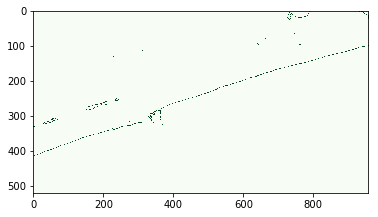

In [37]:
plt.imshow(coastline_2000, cmap='Greens')

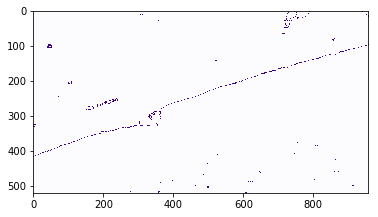

In [38]:
plt.imshow(coastline_2015, cmap='Purples')

In [39]:
mosaic_2000

<xarray.Dataset>
Dimensions:            (latitude: 520, longitude: 957)
Coordinates:
  * latitude           (latitude) float64 6.222 6.222 6.221 6.221 6.221 6.22 ...
  * longitude          (longitude) float64 1.192 1.192 1.192 1.193 1.193 ...
Data variables:
    blue               (latitude, longitude) float32 844.0 863.0 825.0 ...
    green              (latitude, longitude) float32 1202.0 1141.0 1162.0 ...
    red                (latitude, longitude) float32 1568.0 1498.0 1481.0 ...
    nir                (latitude, longitude) float32 2743.0 2666.0 2743.0 ...
    swir1              (latitude, longitude) float32 3490.0 3312.0 3335.0 ...
    swir2              (latitude, longitude) float32 2829.0 2616.0 2616.0 ...
    cf_mask            (latitude, longitude) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    cf_mask_conf       (latitude, longitude) int16 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    adjacent_cloud_qa  (latitude, longitude) int16 255 255 255 255 255 255 ...
    atmos_opacity      (latitude, l

In [40]:
mosaic_rgb_2000 = np.array([mosaic_2000.red.values, mosaic_2000.green.values, mosaic_2000.blue.values])

In [41]:
mosaic_rgb_2000

array([[[ 1568.,  1498.,  1481., ...,   800.,   818.,   593.],
        [ 1533.,  1464.,  1602., ...,   835.,   818.,   652.],
        [ 1464.,  1516.,  1602., ...,   818.,   818.,   652.],
        ..., 
        [  392.,   351.,   412., ...,   375.,   355.,   375.],
        [  392.,   372.,   372., ...,   395.,   375.,   355.],
        [  392.,   372.,   372., ...,   395.,   336.,   355.]],

       [[ 1202.,  1141.,  1162., ...,   863.,   863.,   748.],
        [ 1141.,  1162.,  1182., ...,   883.,   882.,   748.],
        [ 1122.,  1141.,  1141., ...,   883.,   863.,   748.],
        ..., 
        [  514.,   514.,   490., ...,   494.,   518.,   471.],
        [  490.,   490.,   490., ...,   494.,   471.,   471.],
        [  537.,   490.,   490., ...,   494.,   471.,   448.]],

       [[  844.,   863.,   825., ...,   755.,   774.,   771.],
        [  825.,   807.,   807., ...,   755.,   774.,   771.],
        [  807.,   825.,   825., ...,   775.,   774.,   751.],
        ..., 
        [

TypeError: Invalid dimensions for image data

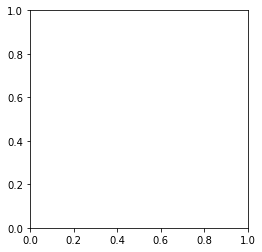

In [43]:
imgplot = plt.imshow(mosaic_rgb_2000)